In [32]:
import requests
import pandas as pd
import urllib
import re
from bs4 import BeautifulSoup
from fbprophet import Prophet
import matplotlib.pyplot as plt
import datetime
import numpy as np

from lxml import html
%matplotlib inline

plt.style.use('fivethirtyeight')

In [18]:
year = []
month = []
day = []
hour = []
minute = []
second = []
wait = []
def parse_page(webpage):
    page = requests.get(webpage)
    tree = html.fromstring(page.content)
    with urllib.request.urlopen(webpage) as url:
        s = url.read()
        soup = BeautifulSoup(s, 'lxml')
        data= soup.find_all("script")[4].string
    data=str(data).replace('\'','').replace('\"','')
    m = re.findall(r'(?<=new Date).*?(?=,,,,,,null,,null)',data)


    for i in m:
        searched =re.match("^.+?\\d$",i)
        if(searched):
            splitted = searched.group(0)[2:searched.group(0).index(' )')].split(',')
            year.append(splitted[0])
            month.append(int(splitted[1])+1)
            day.append(splitted[2])
            hour.append(splitted[3])
            minute.append(splitted[4])
            second.append(splitted[5])
            wait.append(searched.group(0)[searched.group(0).rfind(',')+1:])

In [44]:
def get_time_index(time_string):
    index = 0
    try:
        index = time_string.index('pm')
    except ValueError:
        pass
    try:
        index = time_string.index('am')
    except ValueError:
        'print Can not find open/close time'
    return index

In [51]:
open_times = []
close_times = []
def get_open_close_times(webpage):
    page = requests.get(webpage)
    tree = html.fromstring(page.content)
    with urllib.request.urlopen(webpage) as url:
        s = url.read()
        soup = BeautifulSoup(s, 'lxml')
        open_string = str(soup.find_all("tr")[0])
        open_index = get_time_index(open_string) 
        open_time = open_string[open_index-5:open_index+2].strip()
        close_string = str(soup.find_all("tr")[1])
        close_index = get_time_index(close_string) 
        close_time = close_string[close_index-5:close_index+2].strip()
        open_times.append(open_time)
        close_times.append(close_time)

In [54]:
webpage = 'https://touringplans.com/magic-kingdom/attractions/seven-dwarfs-mine-train/wait-times/date/'

In [62]:
#date_range = pd.date_range(start='2014-05-28', end='2017-11-08', freq='D')
date_range = pd.date_range(start='2017-09-12', end='2017-11-08', freq='D')
for i in date_range:
    #parse_page(webpage+i.strftime("%Y-%m-%d"))
    get_open_close_times(webpage+i.strftime("%Y-%m-%d"))

In [63]:
time_df = pd.DataFrame({'open_time':open_times, 'close_time':close_times})

In [66]:
pd.to_datetime(time_df,format='%H:%M')

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [41]:
df = pd.DataFrame({'year': year,'month': month, 'day': day,'hour':hour,'minute':minute,'second':second
                  })

In [42]:
df2 = pd.to_datetime(df)

In [43]:
df3 = pd.DataFrame({'ds':df2,'y':wait})

In [44]:
df3.to_csv('wait_times.csv')

In [2]:
df3 = pd.read_csv('wait_times.csv')

In [116]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d %H:%M\
:%S')
df = pd.read_csv('wait_times.csv', parse_dates=False, index_col=1,date_parser\
=dateparse, delimiter=',')

In [117]:
df['ds'] = df.index
df.set_index(keys=['Unnamed: 0'],inplace=True)
df.head()

,y,ds
Unnamed: 0,,
0,90,2014-05-28 06:10:20
1,120,2014-05-28 06:18:40
2,180,2014-05-28 06:21:54
3,180,2014-05-28 06:21:54
4,180,2014-05-28 06:24:54


In [118]:
dfnew = df.drop_duplicates('ds',keep='last')

In [119]:
dfnew.set_index(keys=['ds'],inplace=True)
dfnew.head()

,y
ds,
2014-05-28 06:10:20,90
2014-05-28 06:18:40,120
2014-05-28 06:21:54,180
2014-05-28 06:24:54,180
2014-05-28 06:31:17,120


In [122]:
ns5min=15*60*1000000000   # 5 minutes in nanoseconds 
dfnew.index = pd.to_datetime(((dfnew.index.astype(np.int64) // ns5min + 1 ) * ns5min))

In [123]:
dfnew.head()

,y
ds,
2014-05-28 06:15:00,90
2014-05-28 06:30:00,120
2014-05-28 06:30:00,180
2014-05-28 06:30:00,180
2014-05-28 06:45:00,120


In [133]:
dfnew = dfnew[~dfnew.index.duplicated()]

In [134]:
index = pd.date_range('2014-05-28 06:00:00', '2017-11-08 22:56:05', freq='1\
5min')

In [135]:
dfnew.index = pd.DatetimeIndex(dfnew.index)

In [136]:
index = pd.DatetimeIndex(index)

In [137]:
dfnew = dfnew.reindex(index)

In [138]:
dfnew.head()

,y
2014-05-28 06:00:00,NaN
2014-05-28 06:15:00,90.0
2014-05-28 06:30:00,120.0
2014-05-28 06:45:00,120.0
2014-05-28 07:00:00,120.0


In [140]:
dfnew=dfnew.fillna(0)

In [142]:
dfnew['ds']= dfnew.index

In [143]:
my_model = Prophet(interval_width=0.95)
my_model.fit(dfnew)

In [144]:
future_dates = my_model.make_future_dataframe(periods=4*12,freq='15 min')
future_dates.tail()

,ds
121071,2017-11-09 09:45:00
121072,2017-11-09 10:00:00
121073,2017-11-09 10:15:00
121074,2017-11-09 10:30:00
121075,2017-11-09 10:45:00


In [145]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
121071,2017-11-09 09:45:00,57.588644,4.908706,111.873459
121072,2017-11-09 10:00:00,62.173257,2.863698,115.489149
121073,2017-11-09 10:15:00,66.508449,13.010679,120.478690
121074,2017-11-09 10:30:00,70.522849,13.800678,129.929838
121075,2017-11-09 10:45:00,74.159331,18.189724,129.320859


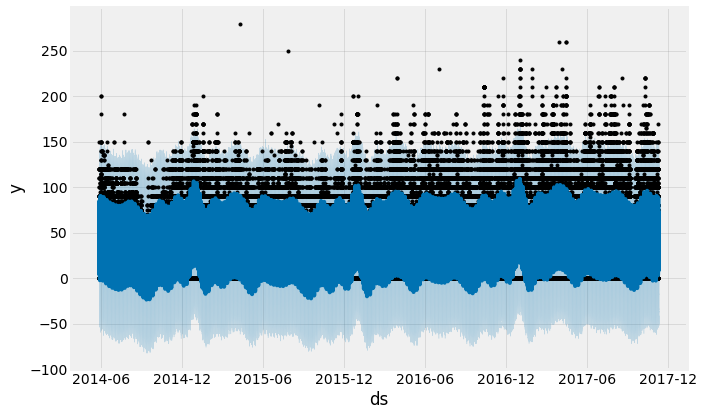

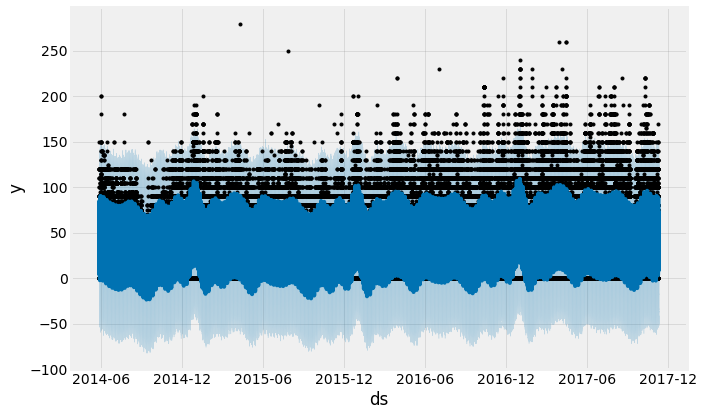

In [151]:
my_model.plot(forecast,
              uncertainty=True)

In [150]:
forecast[-50:][['ds','yhat']]

,ds,yhat
121026,2017-11-08 22:30:00,43.630613
121027,2017-11-08 22:45:00,40.019933
121028,2017-11-08 23:00:00,36.371548
121029,2017-11-08 23:15:00,32.739573
121030,2017-11-08 23:30:00,29.182579
121031,2017-11-08 23:45:00,25.760997
121032,2017-11-09 00:00:00,22.534219
121033,2017-11-09 00:15:00,19.557597
121034,2017-11-09 00:30:00,16.879513
121035,2017-11-09 00:45:00,14.538718


In [152]:
dfnew[0:100]

,y,ds
2014-05-28 06:00:00,0.0,2014-05-28 06:00:00
2014-05-28 06:15:00,90.0,2014-05-28 06:15:00
2014-05-28 06:30:00,120.0,2014-05-28 06:30:00
2014-05-28 06:45:00,120.0,2014-05-28 06:45:00
2014-05-28 07:00:00,120.0,2014-05-28 07:00:00
2014-05-28 07:15:00,120.0,2014-05-28 07:15:00
2014-05-28 07:30:00,60.0,2014-05-28 07:30:00
2014-05-28 07:45:00,60.0,2014-05-28 07:45:00
2014-05-28 08:00:00,60.0,2014-05-28 08:00:00
2014-05-28 08:15:00,60.0,2014-05-28 08:15:00
